In [1]:
import requests
import numpy as np
import pandas as pd
from pyproj import Transformer
from PIL import Image

## Search the geo.admin API


Find the official documentation here: https://api3.geo.admin.ch/

You can use the search API of geo.admin (https://api3.geo.admin.ch/services/sdiservices.html#search) to find the location of addresses, zipcodes and more. Depending on what you search for, you might get more than one result, although the first result should be the most likely. Run the code and then try your own examples or the ones from the documentation in the link above.

In [2]:
_API_URL = 'https://api3.geo.admin.ch/rest/services/api/SearchServer'

In [3]:
def search_api_to_json(searchText, layer):
    url = f"{_API_URL}?type=locations&searchText={searchText}&origins={layer}"
    return requests.get(url).json()

In [4]:
#example
search_api_to_json('5200', 'zipcode')

{'results': [{'id': 1939,
   'weight': 100,
   'attrs': {'origin': 'zipcode',
    'geom_quadindex': '0',
    'zoomlevel': 4294967295,
    'featureId': '8A0215A6-C227-4400-AC21-B92B09633960',
    'lon': 8.206855773925781,
    'detail': '5200',
    'rank': 1,
    'geom_st_box2d': 'BOX(655156.63 257100.151,660179.153 262214.407000001)',
    'lat': 47.485103607177734,
    'num': 1,
    'y': 657899.8125,
    'x': 259654.125,
    'label': '<b>5200 - Brugg AG (AG)</b>'}}]}

In [5]:
# example:
search_api_to_json('bahnhofstrasse 6 windisch', 'address')

{'results': [{'id': 2085814,
   'weight': 7,
   'attrs': {'origin': 'address',
    'geom_quadindex': '021111313202213202203',
    'zoomlevel': 10,
    'featureId': '263003382_0',
    'lon': 8.210972785949707,
    'detail': 'bahnhofstrasse 6 5210 windisch 4123 windisch ch ag',
    'rank': 7,
    'geom_st_box2d': 'BOX(658213.72 259285.985999999,658213.72 259285.985999999)',
    'lat': 47.48176574707031,
    'num': 6,
    'y': 658213.75,
    'x': 259285.984375,
    'label': 'Bahnhofstrasse 6 <b>5210 Windisch</b>'}},
  {'id': 1679035,
   'weight': 4,
   'attrs': {'origin': 'address',
    'geom_quadindex': '021111313202210313320',
    'zoomlevel': 10,
    'featureId': '11002690_0',
    'lon': 8.210947036743164,
    'detail': 'bahnhofstrasse 6.2 5210 windisch 4123 windisch ch ag',
    'rank': 7,
    'geom_st_box2d': 'BOX(658211.535 259314.551999999,658211.535 259314.551999999)',
    'lat': 47.48202133178711,
    'num': 62,
    'y': 658211.5625,
    'x': 259314.546875,
    'label': 'Bahnhofst

## Format Conversion

Format conversion can be a bit tricky - trying it yourself is futile, but fortunately there are python packages available. To find the name of the location formats, go see https://epsg.io/ 

In [6]:
def from_latitude_longitude_to_e_n(lat: float, long: float):
    transformer = Transformer.from_crs("epsg:4326", "epsg:2056")
    return transformer.transform(lat, long)

In [7]:
def from_e_n_to_latitude_longitude(e: float, n: float):
    # part of the exercise
    return 0, 0

In [8]:
def from_lv03_to_lv95(x: float, y: float):
    """Not an exact transformation, but a good aproximation"""
    e = y + 2000000
    n = x + 1000000
    return e,n

## GIS images

You can also use the API to search for images. To define how big the cutout is that you cant, it is easier to avoid using latitude / longitude.

In [11]:
def get_gis_image_url(e, n, radius, layers):
    l_e, r_e, t_n, b_n = e - radius, e + radius, n - radius, n + radius
    return f"https://wms.geo.admin.ch/?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&FORMAT=image%2Fpng&TRANSPARENT=false&LAYERS={','.join(layers)}&WIDTH={256}&HEIGHT={256}&CRS=epsg%3A2056&STYLES=&BBOX={l_e}%2C{t_n}%2C{r_e}%2C{b_n}"

In [12]:
latitude, longitude = 47.48196574707031, 8.211122785949707
e, n = from_latitude_longitude_to_e_n(latitude, longitude)
image_url = get_gis_image_url(e, n, 250, ['ch.kantone.cadastralwebmap-farbe'])

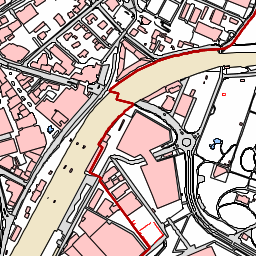

In [13]:
img = Image.open(requests.get(image_url, stream=True).raw)
img

## Exercise Cleaning GeoData

You have a dataset with a column that just says "location". It contains addresses, longitude / latitude (sometimes in the wrong order) and coordinates in the LV95  format. You do know however, that all locations are supposed to be somewhere in Switzerland (so a latitude between 45 and 48 and longitude between 5 and 11). Write a function that takes this undefined input and given longitude and latitude as output. Then apply this function to the dataset to get two new columns.

In [14]:
df = pd.read_excel("locations.xlsx")
df

,location,Country,measurement
0,"46.585607,7.785153",CH,9.3
1,"46.746794,8.651131",CH,69.7
2,"47.165476, 7.071886",CH,68.4
3,"46.933067,8.600839",Schweiz,64.8
4,"2657474, 12574324",CH,50.9
5,"2659831, 12561239",CH,40.1
6,"5210, Windisch",Switzerland,47.5
7,"""46.688389,8.866704""",CH,15.8
8,"47.612133,8.380114",Schweiz,15.4
9,"8.917436,46.460269,",CH,95.3


In [15]:
def extract_lat_long(x):
    # TODO: this code is to get you started and will convert many of the values in this dataframe correctly. 
    # Expand this function with more functionality, to automatically convert as many entries as possible to the
    # correct latitude and longitude values.
    latlong = x.split(',')
    if(len(latlong) == 2):
        return latlong[0], latlong[1]
    return 0,0

In [16]:
# applies the function above to the location field in the dataframe and adds two new columns lat and long
df["lat"], df["long"] = zip(*df["location"].map(extract_lat_long))
df

,location,Country,measurement,lat,long
0,"46.585607,7.785153",CH,9.3,46.585607,7.785153
1,"46.746794,8.651131",CH,69.7,46.746794,8.651131
2,"47.165476, 7.071886",CH,68.4,47.165476,7.071886
3,"46.933067,8.600839",Schweiz,64.8,46.933067,8.600839
4,"2657474, 12574324",CH,50.9,2657474,12574324
5,"2659831, 12561239",CH,40.1,2659831,12561239
6,"5210, Windisch",Switzerland,47.5,5210,Windisch
7,"""46.688389,8.866704""",CH,15.8,"""46.688389","8.866704"""
8,"47.612133,8.380114",Schweiz,15.4,47.612133,8.380114
9,"8.917436,46.460269,",CH,95.3,0,0
